# Ablauf

1) Daten einlesen
2) Daten aufebereiten
    -   Ausreißer identifizieren
3) GSMP-Kenndaten aufbereiten
4) Analyse
    -   Scatterplot Jobs auf Watt + Regression
    -   line chart auf bar chart
    -   Berechnung pro Worker - Idle

# 1. Daten einlesen

### CSV einlesen

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

#read kepler CSV
worker_power = pd.read_csv("CSV-start-duration/2024-02-07 19-06-00 start duration power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels
#read zeebe CSV
worker_jobs = pd.read_csv("CSV-start-duration/2024-02-07 19-06-00 start duration jobs.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

worker_up = pd.read_csv("CSV-start-duration/2024-02-07 19-06-00 start duration up.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

worker_up

,"{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.50:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-7j585"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.51:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-4bfz7"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.52:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-xpccb"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.53:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-rkpct"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.54:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-n8db9"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.55:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-qjdwz"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.56:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-b4wg8"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.57:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-jptv2"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.58:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-xxsjq"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.59:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-bsdct"", service=""restworkerjava""}",...,"{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.70:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-jdhfc"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.71:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-bzwhz"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.72:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-ptmv5"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.73:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-qqb25"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.74:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-stxpk"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.75:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-klg2j"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.76:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-rt69j"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.77:8080"", job=""restworkerjava"", namespace=""worker"", pod=""restworkerjava-56c6fcc879-6q7jv"", service=""restworkerjava""}","{__name__=""up"", container=""restworkerjava"", endpoint=""http"", instance=""10.42.0.78:8080"", job=""restworkerjava"", namespace=""worker"",

In [125]:
# create full index

ind = []

for i in range ((30*18)+60):
   a = f"2024-02-07 {19+((i)//360):02d}:{(((i // 6))%60):02d}:{(i%6 *10):02d}"
   ind.append(a)

ind

['2024-02-07 19:00:00',
 '2024-02-07 19:00:10',
 '2024-02-07 19:00:20',
 '2024-02-07 19:00:30',
 '2024-02-07 19:00:40',
 '2024-02-07 19:00:50',
 '2024-02-07 19:01:00',
 '2024-02-07 19:01:10',
 '2024-02-07 19:01:20',
 '2024-02-07 19:01:30',
 '2024-02-07 19:01:40',
 '2024-02-07 19:01:50',
 '2024-02-07 19:02:00',
 '2024-02-07 19:02:10',
 '2024-02-07 19:02:20',
 '2024-02-07 19:02:30',
 '2024-02-07 19:02:40',
 '2024-02-07 19:02:50',
 '2024-02-07 19:03:00',
 '2024-02-07 19:03:10',
 '2024-02-07 19:03:20',
 '2024-02-07 19:03:30',
 '2024-02-07 19:03:40',
 '2024-02-07 19:03:50',
 '2024-02-07 19:04:00',
 '2024-02-07 19:04:10',
 '2024-02-07 19:04:20',
 '2024-02-07 19:04:30',
 '2024-02-07 19:04:40',
 '2024-02-07 19:04:50',
 '2024-02-07 19:05:00',
 '2024-02-07 19:05:10',
 '2024-02-07 19:05:20',
 '2024-02-07 19:05:30',
 '2024-02-07 19:05:40',
 '2024-02-07 19:05:50',
 '2024-02-07 19:06:00',
 '2024-02-07 19:06:10',
 '2024-02-07 19:06:20',
 '2024-02-07 19:06:30',
 '2024-02-07 19:06:40',
 '2024-02-07 19:

In [126]:
LOG_PATH = "shell-scripts/logs/"
LOG_NAME = "2024-02-07-19-06-00-duratiom-start-test"

#read starting times
with open(LOG_PATH+LOG_NAME, "r") as file:
    start_times = file.readlines()
 
# remove newline-character, 
for i, time in enumerate(start_times):
    start_times[i] = time[:-1]

start_times

['2024-02-07 19:06:00',
 '2024-02-07 19:09:00',
 '2024-02-07 19:12:00',
 '2024-02-07 19:15:00',
 '2024-02-07 19:18:00',
 '2024-02-07 19:21:00',
 '2024-02-07 19:24:00',
 '2024-02-07 19:27:00',
 '2024-02-07 19:30:00',
 '2024-02-07 19:33:10',
 '2024-02-07 19:36:10',
 '2024-02-07 19:39:10',
 '2024-02-07 19:42:10',
 '2024-02-07 19:45:10',
 '2024-02-07 19:48:10',
 '2024-02-07 19:51:10',
 '2024-02-07 19:54:10',
 '2024-02-07 19:57:10',
 '2024-02-07 20:00:10',
 '2024-02-07 20:03:20',
 '2024-02-07 20:06:20',
 '2024-02-07 20:09:20',
 '2024-02-07 20:12:20',
 '2024-02-07 20:15:20',
 '2024-02-07 20:18:20',
 '2024-02-07 20:21:20',
 '2024-02-07 20:24:20',
 '2024-02-07 20:27:30',
 '2024-02-07 20:30:30',
 '2024-02-07 20:33:30']

In [127]:
# relative tmestamps

rt = []

for i in range(18):
    rt.append(f"{(i // 6):02d}:{(i%6*10):02d} - {((i+1) // 6):02d}:{((i+1)%6*10):02d}")

rt

['00:00 - 00:10',
 '00:10 - 00:20',
 '00:20 - 00:30',
 '00:30 - 00:40',
 '00:40 - 00:50',
 '00:50 - 01:00',
 '01:00 - 01:10',
 '01:10 - 01:20',
 '01:20 - 01:30',
 '01:30 - 01:40',
 '01:40 - 01:50',
 '01:50 - 02:00',
 '02:00 - 02:10',
 '02:10 - 02:20',
 '02:20 - 02:30',
 '02:30 - 02:40',
 '02:40 - 02:50',
 '02:50 - 03:00']

In [157]:
power_series = worker_power.median(axis=1)
up_series = worker_up.sum(axis=1)

# Create DataFrame B
B = pd.DataFrame(index=ind)

# Check for numeric values in each row of DataFrame A
# B['power'] = worker_power.median(axis=1)
# B['jobs'] = worker_jobs['worker']

B['power'] = power_series
B['jobs'] = worker_jobs['worker']
B['up'] = up_series


B = B.fillna(0)

B['up']

2024-02-07 19:00:00    0.0
2024-02-07 19:00:10    0.0
2024-02-07 19:00:20    0.0
2024-02-07 19:00:30    0.0
2024-02-07 19:00:40    0.0
                      ... 
2024-02-07 20:39:10    0.0
2024-02-07 20:39:20    0.0
2024-02-07 20:39:30    0.0
2024-02-07 20:39:40    0.0
2024-02-07 20:39:50    0.0
Name: up, Length: 600, dtype: float64

In [142]:
cycles = []

for t in start_times:
    i = B.index.get_loc(t)
    
    temp = B.iloc[i:i+18,:]

    cycles.append(temp)


In [172]:
start_durations = []

for t in start_times:
    i = B.index.get_loc(t)

    for j in range(0,12,1):
        if B['up'][i + j] == 1:
            start_durations.append(j-5)
            break
    
start_durations = pd.Series(start_durations)
start_durations.mean()


3.066666666666667

In [174]:
stop_durations = []

for t in start_times:
    i = B.index.get_loc(t) + 12 # 2 minutes (12 scrapes) later, the pod will be shut down

    for j in range(0,6,1):
        if B['up'][i + j] == 0:
            stop_durations.append(j+1)
            break
    
stop_durations = pd.Series(stop_durations)

stop_durations.mean()


2.566666666666667

<Axes: >

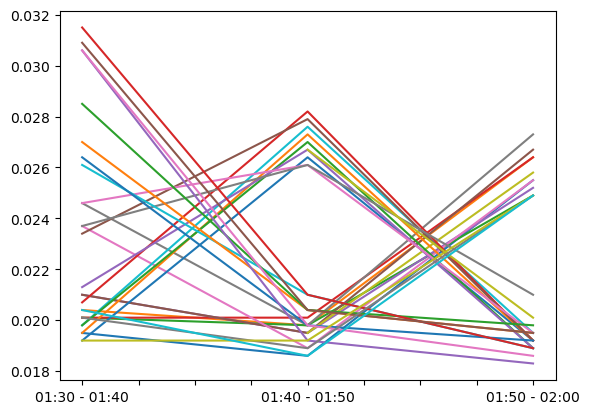

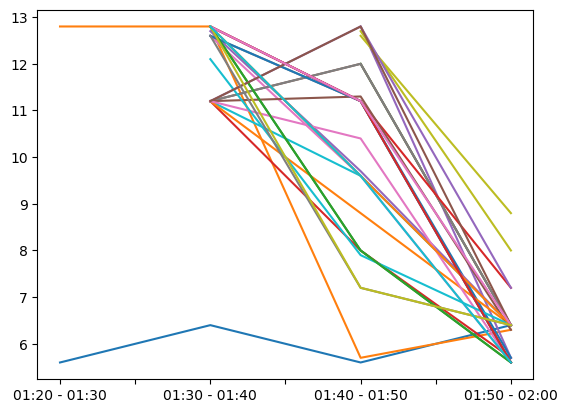

In [143]:
relative_jobs = pd.DataFrame()
relative_power = pd.DataFrame()

for c in cycles:
    relative_jobs = pd.concat([relative_jobs, c['jobs'].reset_index(drop=True)], axis=1)
    relative_power = pd.concat([relative_power, c['power'].reset_index(drop=True)], axis=1)

relative_power.index = rt
relative_jobs.index = rt

relative_power = relative_power.iloc[8:12,:]
relative_jobs = relative_jobs.iloc[8:12,:]

relative_power.plot(legend=False)
relative_jobs.plot(legend=False)

In [144]:
groups_power.index = rt
groups_jobs.index = rt

groups_power.plot(rot=90, figsize=[12,8], xticks=[0,3,6,9,12], grid=True)
groups_jobs.plot(rot=90, figsize=[12,8], xticks=[0,3,6,9,12], grid=True)

ValueError: Length mismatch: Expected axis has 15 elements, new values have 18 elements

### Messwerte aus Kepler addieren

<Axes: xlabel='Time'>

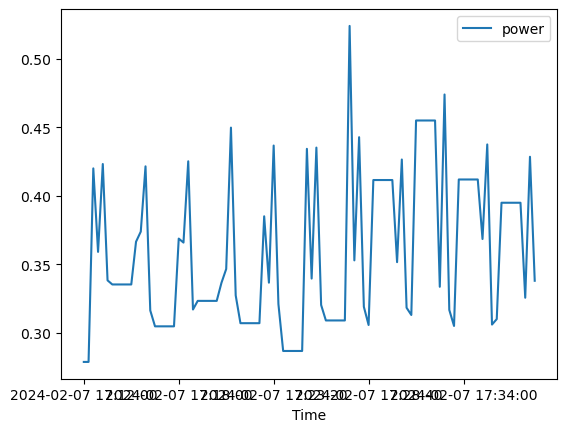

In [ ]:
completion_and_power = pd.DataFrame()

worker_cols = [col for col in worker_power.columns if 'restworkerjava' in col ]

# sum up PKG + DRAM + OTHER for each time stamp
completion_and_power['power'] = worker_power[worker_cols].sum(axis=1)

completion_and_power.plot()



### Vereine Completion und Power


<Axes: title={'center': 'Energy Consumption of Worker and corresponding Job Completion'}, xlabel='Time'>

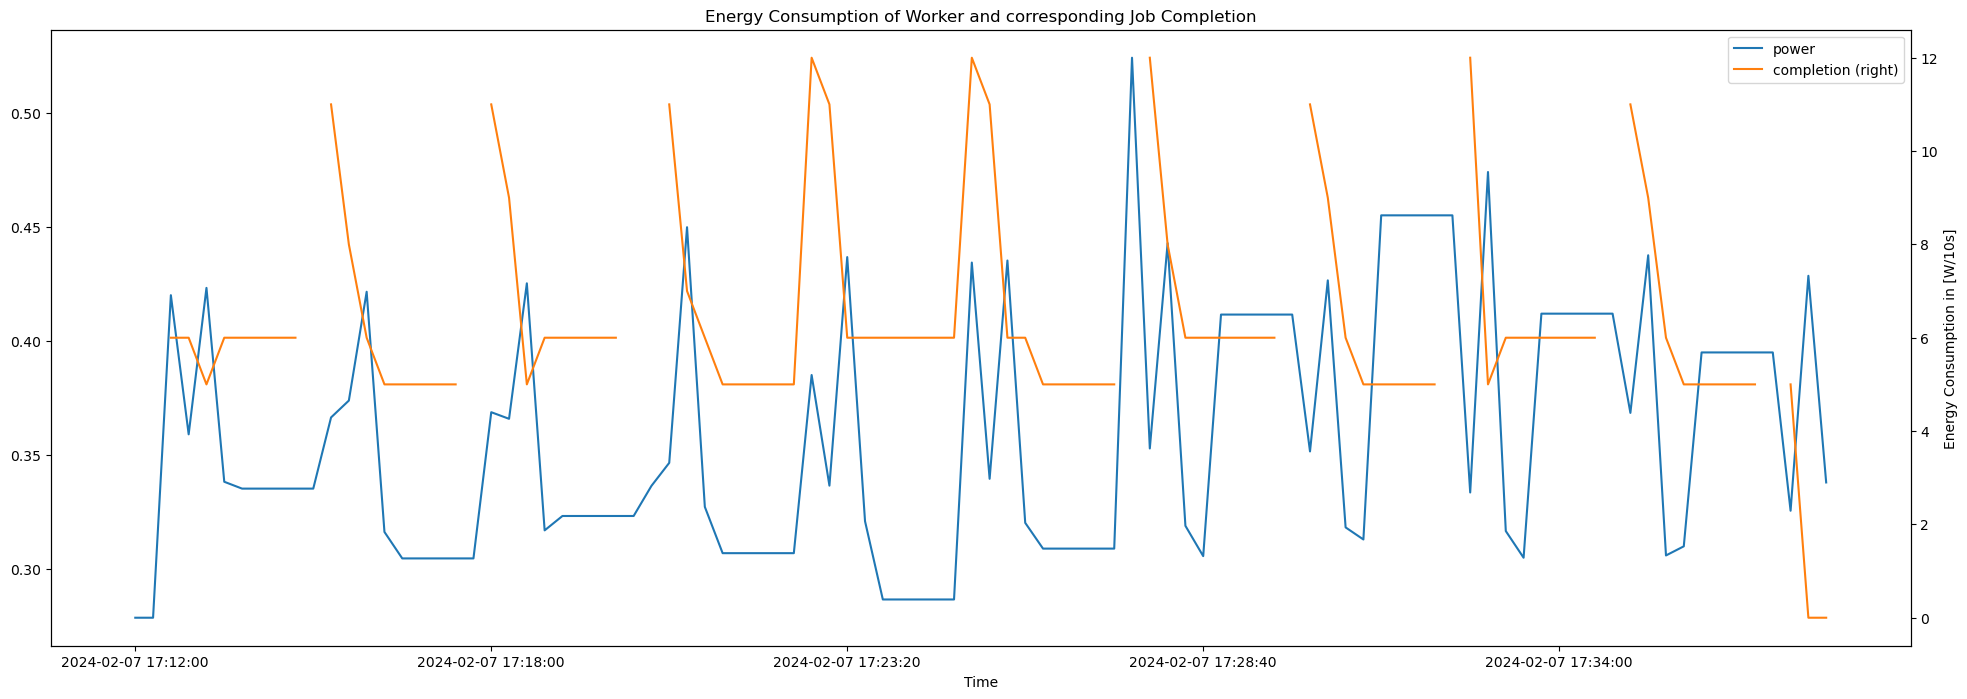

In [ ]:
# add job throughput
completion_and_power['completion'] = worker_jobs.iloc[:,0]

# floor job throughput
completion_and_power['completion'] = completion_and_power['completion'] // 1

completion_and_power.plot(
    figsize=[24,8], 
    ylabel='Energy Consumption in [W/10s]',
    secondary_y='completion',
    title='Energy Consumption of Worker and corresponding Job Completion',
    )

### Generiere Leerlauf-Muster + Subtrahiere Leerlauf-Muster

In [ ]:
# set all completion >= 1 to NaN

idle_power = completion_and_power.copy()
idle_power[idle_power['completion'] >= 1] = np.nan


# generate medians for 00:00, 00:10, 00:20

# reshape series
idle_pattern = pd.DataFrame(idle_power['power'][:-1].to_numpy().reshape(-1, 3), columns=['00:00', '00:10', '00:20'])

medians = idle_pattern.median(axis=0)

medians


ValueError: cannot reshape array of size 95 into shape (3)

In [ ]:
def remove_idle_power(df, pattern):
    pattern_series = pd.Series()
    
    difference = 0
    
    # repeat the pattern until length of df.index is reached
    while len(pattern_series) < len(df.index):
        pattern_series = pd.concat([pattern_series, pattern])
        difference = len(pattern_series) - len(df.index)
    
    print(difference)

    pattern_series = pattern_series[:-difference]
    pattern_series.index = df.index

    pattern_series = pattern_series.apply(pd.to_numeric, errors='coerce')

    df['no_idle'] = df['power'] - pattern_series
    df['idle'] = pattern_series


    return df

cap_no_idle = remove_idle_power(completion_and_power, medians)

cap_no_idle


2


,power,completion,no_idle,idle
Time,,,,
2024-02-05 21:01:00,0.2041,0.0,-0.00100,0.20510
2024-02-05 21:01:10,0.2028,0.0,0.00005,0.20275
2024-02-05 21:01:20,0.2715,0.0,-0.00130,0.27280
2024-02-05 21:01:30,0.2041,0.0,-0.00100,0.20510
2024-02-05 21:01:40,0.2038,0.0,0.00105,0.20275
...,...,...,...,...
2024-02-06 07:45:50,0.2738,NaN,0.00100,0.27280
2024-02-06 07:46:00,0.2041,NaN,-0.00100,0.20510
2024-02-06 07:46:10,0.2011,NaN,-0.00165,0.20275


### Generiere Durchsatz pro Job

In [ ]:
cap_no_idle['per_job_no_idle'] = cap_no_idle['no_idle'] / cap_no_idle['completion']

### Entferne Leerlauf-Werte

In [ ]:
cap_no_idle = cap_no_idle[cap_no_idle['completion'] >= 1]

# sort df
cap_sorted = cap_no_idle.sort_values(by='completion')

## Generiere Durchsatz-Buckets pro Job


In [ ]:
# Bucket Params

bucket_size = 20

# create limits for buckets
max_throughput = int(cap_sorted['completion'].max())
min_throughput = int(cap_sorted['completion'].min())
span_throughput = int(max_throughput - min_throughput)

# number of buckets
num_buckets = (span_throughput // bucket_size) + 1

In [ ]:
# create new df
cap_grouped = pd.DataFrame()
temp_cols = []
xlabels= []

# create df holding idle info
idle_grouped = pd.DataFrame()

# create list of buckets
cap_grouped_list = [cap_sorted[
                            (cap_sorted['completion'] >= (max_throughput - i - bucket_size))
                            & 
                            (cap_sorted['completion'] < (max_throughput - i )) 
                            ] 
                            for i in range(0, span_throughput, bucket_size)
                    ]

# reverse list
cap_grouped_list.reverse()

# create list of bucket labels
bucket_labels = [f"{cap_sorted['completion'][i]} Jobs/s" for i in range(0, len(cap_sorted), bucket_size)]


# consolidate into single df
for  i, b in enumerate(cap_grouped_list):

    # add bucket to per-job df
    cap_grouped = pd.concat([cap_grouped, b['per_job_no_idle'].reset_index(drop=True)], axis=1)

    # add bucket to idle df
    idle_grouped = pd.concat([idle_grouped, b['idle'].reset_index(drop=True)], axis=1)
    temp_cols.append(i * bucket_size)
    xlabels.append(f"{b['completion'].min()} - {b['completion'].max()}")


# format per-job df
cap_grouped = cap_grouped.apply(pd.to_numeric, errors='coerce')
cap_grouped.columns = temp_cols

# format idle df
idle_grouped = idle_grouped.apply(pd.to_numeric, errors='coerce')
idle_grouped.columns = temp_cols

xlabels


['1.0 - 11.0',
 '12.0 - 31.0',
 '32.0 - 51.0',
 '52.0 - 71.0',
 '72.0 - 91.0',
 '92.0 - 111.0',
 '112.0 - 131.0',
 '132.0 - 151.0',
 '152.0 - 171.0',
 '172.0 - 191.0',
 '192.0 - 211.0',
 '212.0 - 231.0',
 '232.0 - 251.0']

### Prüfe Bucket Size

In [ ]:
has_more_than_30_values = pd.Series([len(cap_grouped[column].dropna()) for column in cap_grouped.columns], index=cap_grouped.columns)

# Display the Series
print(has_more_than_30_values)

0      291
20     366
40     195
60     102
80     177
100    187
120    213
140    195
160    243
180    309
200    176
220     75
240     29
dtype: int64


### Entferne Ausreißer

In [ ]:
def filter_outliers_iqr_per_column(column, multiplier=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((column < lower_bound) | (column > upper_bound))
    return column[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_column, axis=0).apply(pd.to_numeric, errors='coerce')


cap_clean = filter_outliers_iqr(cap_grouped)

## Generiere Durchsatz-Buckets Gesamtverbrauch (ohne Idle)

In [ ]:
# create new df
total_grouped = pd.DataFrame()
temp_cols_total = []

# create list of buckets
total_grouped_list = [cap_sorted[
                            (cap_sorted['completion'] >= (max_throughput - i - bucket_size))
                            & 
                            (cap_sorted['completion'] < (max_throughput - i )) 
                            ] 
                            for i in range(0, span_throughput, bucket_size)
                    ]

# reverse list
total_grouped_list.reverse()

# create list of bucket labels
bucket_labels = [f"{cap_sorted['completion'][i]} Jobs/s" for i in range(0, len(cap_sorted), bucket_size)]


# consolidate into single df
for  i, b in enumerate(total_grouped_list):
    total_grouped = pd.concat([total_grouped, b['no_idle'].reset_index(drop=True)], axis=1)
    temp_cols_total.append(i * bucket_size)

total_grouped = total_grouped.apply(pd.to_numeric, errors='coerce')


temp_cols_total
total_grouped.columns = temp_cols_total

total_grouped_list[0]

,power,completion,no_idle,idle,per_job_no_idle
Time,,,,,
2024-02-06 07:04:40,0.2113,1.0,0.00855,0.20275,0.008550
2024-02-06 05:24:40,0.2083,1.0,0.00555,0.20275,0.005550
2024-02-06 02:49:30,0.2048,1.0,-0.00030,0.20510,-0.000300
2024-02-06 02:21:20,0.2866,1.0,0.01380,0.27280,0.013800
2024-02-06 01:48:00,0.2166,1.0,0.01150,0.20510,0.011500
...,...,...,...,...,...
2024-02-05 23:36:20,0.3080,11.0,0.03520,0.27280,0.003200
2024-02-06 00:10:00,0.2378,11.0,0.03270,0.20510,0.002973
2024-02-06 04:19:40,0.2160,11.0,0.01325,0.20275,0.001205


### Entferne Ausreißer

In [ ]:
def filter_outliers_iqr_per_column(column, multiplier=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((column < lower_bound) | (column > upper_bound))
    return column[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_column, axis=0).apply(pd.to_numeric, errors='coerce')

total_clean = filter_outliers_iqr(total_grouped)

### Plot Result

In [ ]:
# define Colors

lightgreen = "#6ccbb2"
green = "#437e6e"
darkblue = "#90c5e2"
blue = "#a2d8ff"
black = "#1f1f1f"
grey = "#f3f3f2"
white = "#ffffff"

[Text(1, 0, '1.0 - 11.0'),
 Text(2, 0, '12.0 - 31.0'),
 Text(3, 0, '32.0 - 51.0'),
 Text(4, 0, '52.0 - 71.0'),
 Text(5, 0, '72.0 - 91.0'),
 Text(6, 0, '92.0 - 111.0'),
 Text(7, 0, '112.0 - 131.0'),
 Text(8, 0, '132.0 - 151.0'),
 Text(9, 0, '152.0 - 171.0'),
 Text(10, 0, '172.0 - 191.0'),
 Text(11, 0, '192.0 - 211.0'),
 Text(12, 0, '212.0 - 231.0'),
 Text(13, 0, '232.0 - 251.0')]

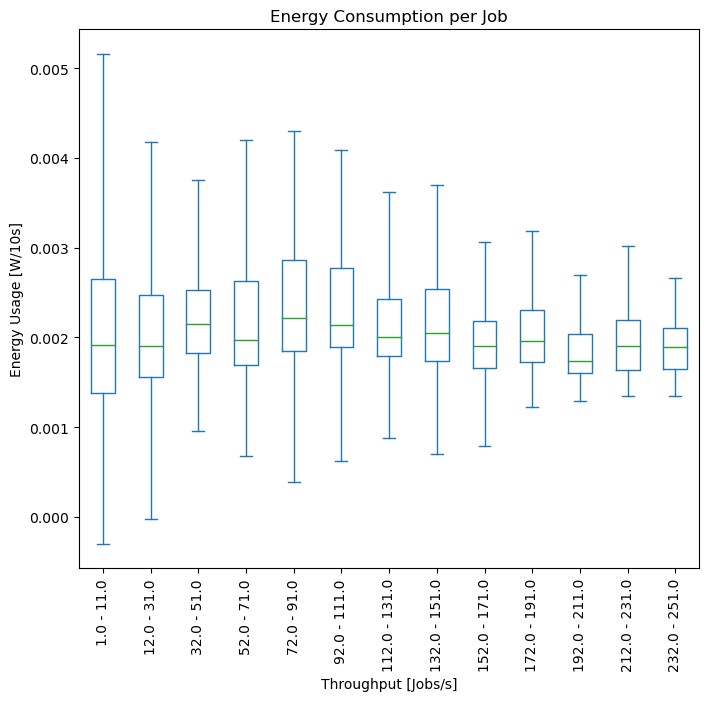

In [ ]:
figsize = [15,5]

ax = cap_clean.plot(
        kind='box',
        figsize=[8,7],
        rot = 90, 
        whis=[0,100],
        title="Energy Consumption per Job",
        xlabel="Throughput [Jobs/s]",
        ylabel="Energy Usage [W/10s]"
)
ax.set_xticklabels(xlabels)

[Text(1, 0, '1.0 - 11.0'),
 Text(2, 0, '12.0 - 31.0'),
 Text(3, 0, '32.0 - 51.0'),
 Text(4, 0, '52.0 - 71.0'),
 Text(5, 0, '72.0 - 91.0'),
 Text(6, 0, '92.0 - 111.0'),
 Text(7, 0, '112.0 - 131.0'),
 Text(8, 0, '132.0 - 151.0'),
 Text(9, 0, '152.0 - 171.0'),
 Text(10, 0, '172.0 - 191.0'),
 Text(11, 0, '192.0 - 211.0'),
 Text(12, 0, '212.0 - 231.0'),
 Text(13, 0, '232.0 - 251.0')]

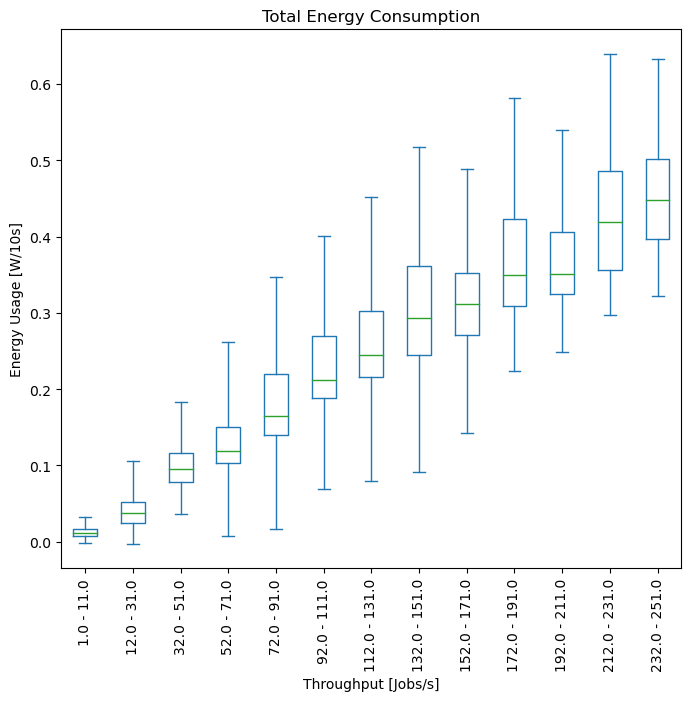

In [ ]:
ax = total_clean.plot(
        kind='box',
        figsize=[8,7],
        rot = 90, 
        whis=[0,100],
        title="Total Energy Consumption",
        xlabel="Throughput [Jobs/s]",
        ylabel="Energy Usage [W/10s]"
)
ax.set_xticklabels(xlabels)

0.0017408559276980333 0.002212671232876713 1.2710249008386179


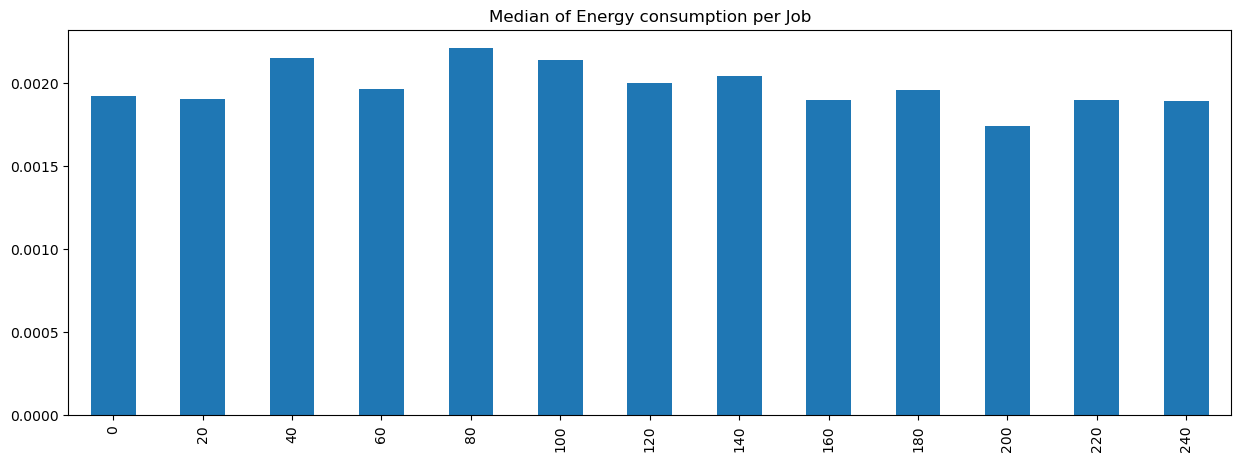

In [ ]:
cap_clean.median(axis=0).plot(
    kind='bar',
    figsize=figsize,
    title='Median of Energy consumption per Job'
)

min_med = cap_clean.median(axis=0).min()
max_med = cap_clean.median(axis=0).max()

print(min_med, max_med, max_med/min_med)

0.011300000000000032 0.4481000000000001 39.65486725663706
0.22743991414421205
0      0.011300
20     0.037700
40     0.095900
60     0.119600
80     0.165325
100    0.211800
120    0.244550
140    0.293500
160    0.311850
180    0.349400
200    0.351300
220    0.418750
240    0.448100
dtype: float64


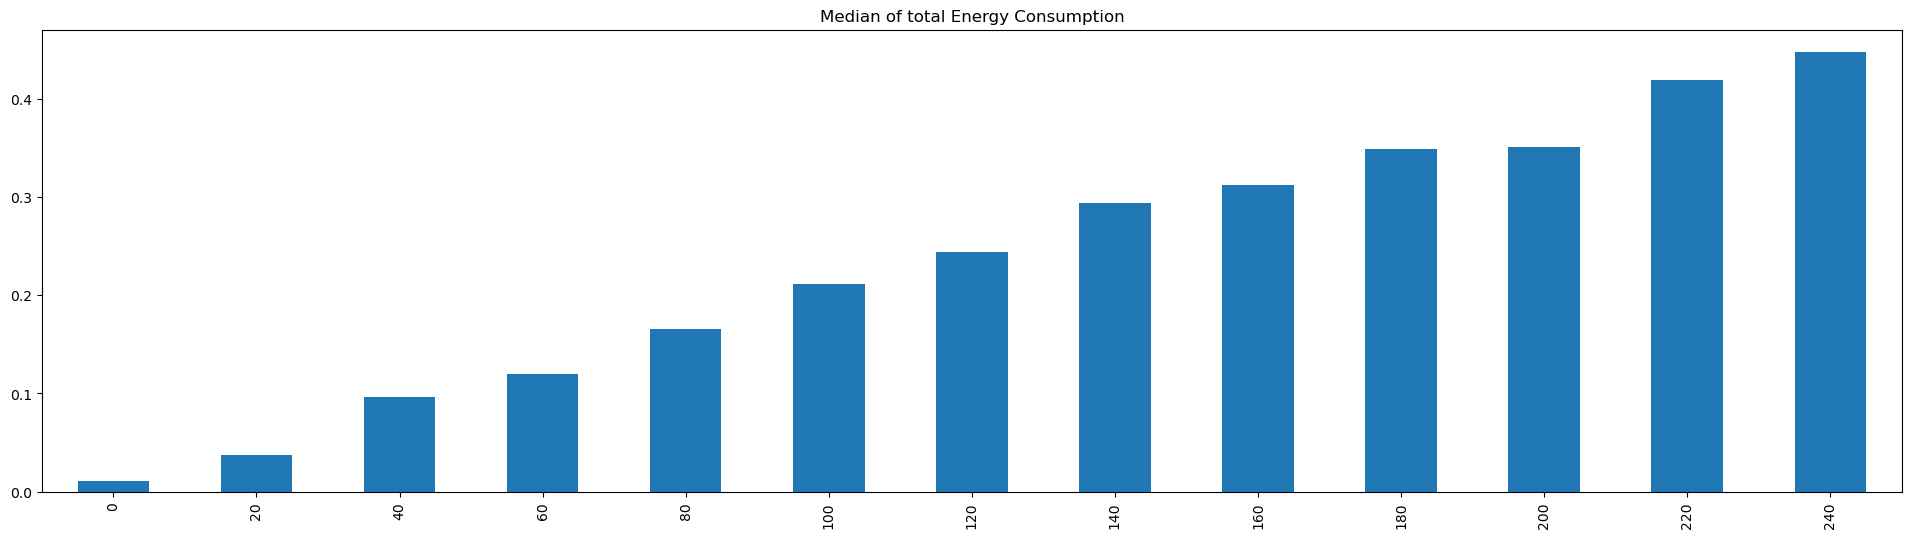

In [ ]:
total_clean.median(axis=0).plot(
    kind='bar',
    figsize=figsize,
    title="Median of total Energy Consumption"
)

min_med = total_clean.median(axis=0).min()
max_med = total_clean.median(axis=0).max()

print(min_med, max_med, max_med/min_med)
print(idle_pattern.mean().mean())
print(total_clean.median(axis=0))


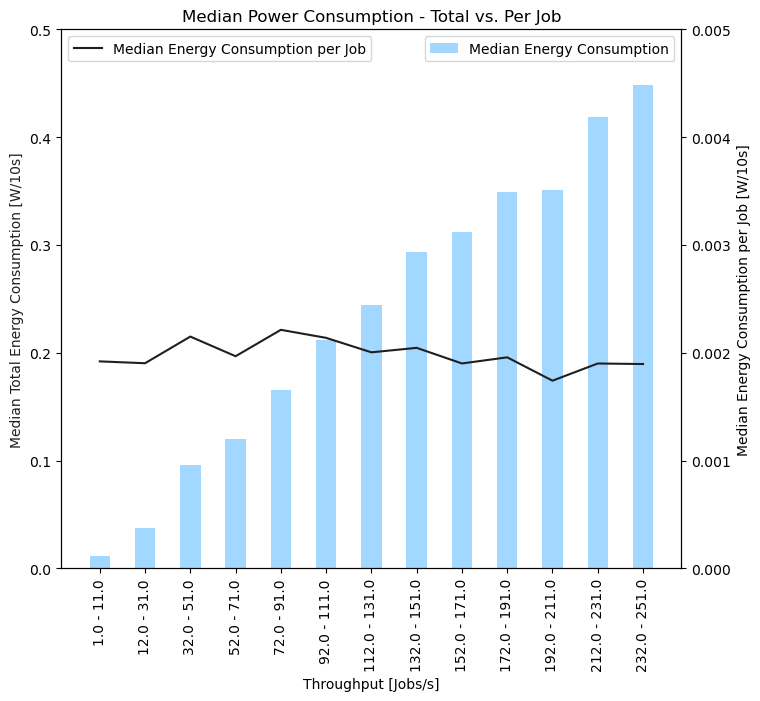

In [ ]:
# Create a figure and axis for the first series
fig, ax1 = plt.subplots(figsize=[8,7])

xlabel_pos = [range(0,num_buckets)]

# Plot the first series as a line graph
ax1.bar(total_clean.median().index, 
        total_clean.median().values, 
        color= blue, 
        width=9,
        label='Median Energy Consumption'
        )

# Add labels and legend for the first y-axis
ax1.set_xlabel('Throughput [Jobs/s]')
ax1.set_ylabel('Median Total Energy Consumption [W/10s]', color=black)
ax1.legend(loc='upper right')

ax1.set_xticks(total_clean.median().index)
ax1.set_xticklabels(xlabels, rotation=90)


# Create a secondary y-axis for the second series
ax2 = ax1.twinx()

# Plot the second series as a bar chart
ax2.plot(cap_clean.median().index, 
         cap_clean.median().values, 
         label='Median Energy Consumption per Job', 
         color=black,
         )

# Add labels and legend for the second y-axis
ax2.set_ylabel('Median Energy Consumption per Job [W/10s]')
ax2.legend(loc='upper left')
ax1.set_ylim(0,0.5)
ax2.set_ylim(0,0.005)

ax1.set_title("Median Power Consumption - Total vs. Per Job")
# Show the plot

plt.show()

In [ ]:
idle_grouped

,0,20,40,60,80,100,120,140,160,180,200,220,240
0,0.20275,0.20510,0.20275,0.20510,0.20510,0.27280,0.20275,0.27280,0.20275,0.20275,0.20275,0.2728,0.20510
1,0.20275,0.20510,0.27280,0.20510,0.20510,0.20510,0.20275,0.20510,0.20275,0.27280,0.20510,0.2728,0.27280
2,0.20510,0.27280,0.20275,0.20510,0.20275,0.20510,0.27280,0.20275,0.20510,0.20510,0.20275,0.2051,0.27280
3,0.27280,0.27280,0.20510,0.20275,0.27280,0.20510,0.27280,0.20275,0.27280,0.20275,0.27280,0.2051,0.20275
4,0.20510,0.20275,0.20510,0.27280,0.20510,0.20275,0.20510,0.20510,0.27280,0.27280,0.20275,0.2728,0.27280
...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,NaN,0.20275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,NaN,0.20510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,NaN,0.20510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,NaN,0.20510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


idle     float64
total    float64
dtype: object


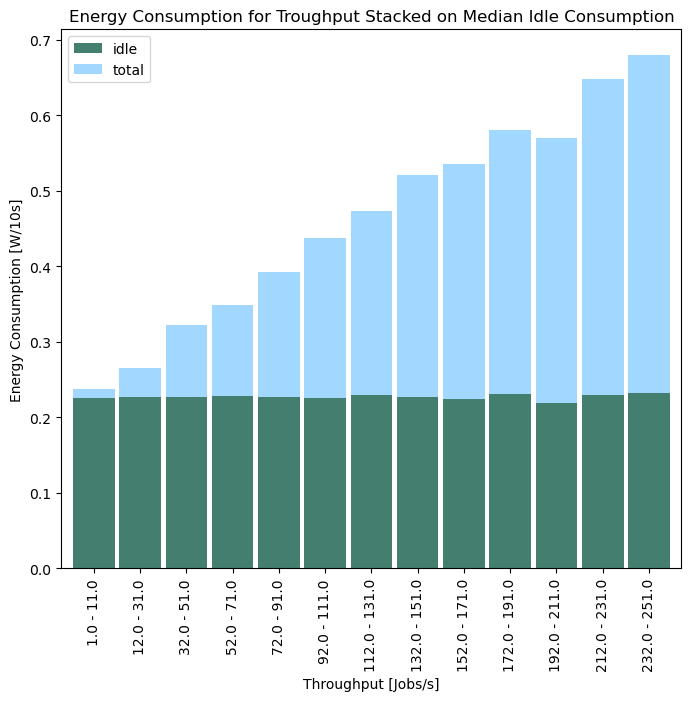

In [ ]:
temp = pd.DataFrame()
temp['total'] = total_clean.median().reset_index(drop=True)
temp['idle'] = idle_grouped.mean(skipna=True).reset_index(drop=True)
# temp['per_worker'] = cap_clean.median().reset_index(drop=True)

# Reverse the order of columns
temp = temp[temp.columns[::-1]]

temp.index = xlabels
print(temp.dtypes)
ax1 = temp.plot(
    figsize=[8,7],
    kind='bar',
    stacked=True,
    color=[green,blue],
    width=0.9,
    title="Energy Consumption for Troughput Stacked on Median Idle Consumption",
    xlabel="Throughput [Jobs/s]",
    ylabel="Energy Consumption [W/10s]"
)

['1.0 - 11.0', '12.0 - 31.0', '32.0 - 51.0', '52.0 - 71.0', '72.0 - 91.0', '92.0 - 111.0', '112.0 - 131.0', '132.0 - 151.0', '152.0 - 171.0', '172.0 - 191.0', '192.0 - 211.0', '212.0 - 231.0', '232.0 - 251.0']


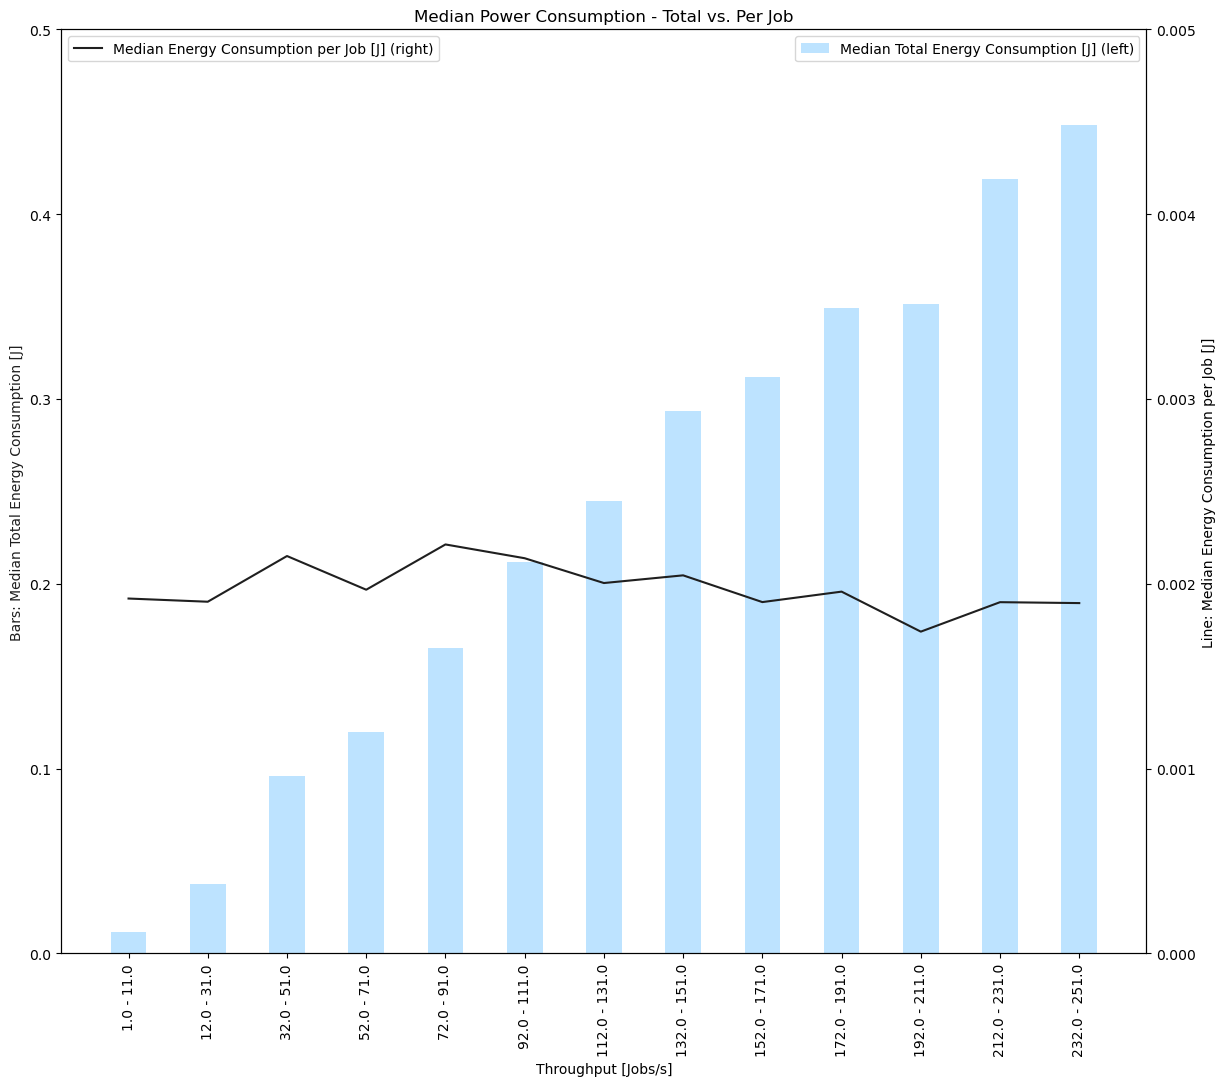

In [ ]:
# Create a figure and axis for the first series
fig, ax1 = plt.subplots(figsize=[14,12])

xlabel_pos = [range(0,num_buckets)]

# Plot the first series as a line graph
ax1.bar(total_clean.median().index, 
        total_clean.median().values, 
        label='Median Total Energy Consumption [J] (left)', 
        color= blue, 
        alpha=0.7,
        width=9, 
        )

# Add labels and legend for the first y-axis
ax1.set_xlabel('Throughput [Jobs/s]')
ax1.set_ylabel('Bars: Median Total Energy Consumption [J]', color=black)
ax1.legend(loc='upper right')
print(xlabels)
ax1.set_xticks(total_clean.median().index)
ax1.set_xticklabels(xlabels, rotation=90)


# Create a secondary y-axis for the second series
ax2 = ax1.twinx()

# Plot the second series as a bar chart
ax2.plot(cap_clean.median().index, 
         cap_clean.median().values, 
         label='Median Energy Consumption per Job [J] (right)', 
         color=black
         )

# Add labels and legend for the second y-axis
ax2.set_ylabel('Line: Median Energy Consumption per Job [J]')
ax2.set_ylim(0,0.005)
ax1.set_ylim(0,0.5)
ax2.legend(loc='upper left')

ax1.set_title("Median Power Consumption - Total vs. Per Job")
# Show the plot

plt.show()

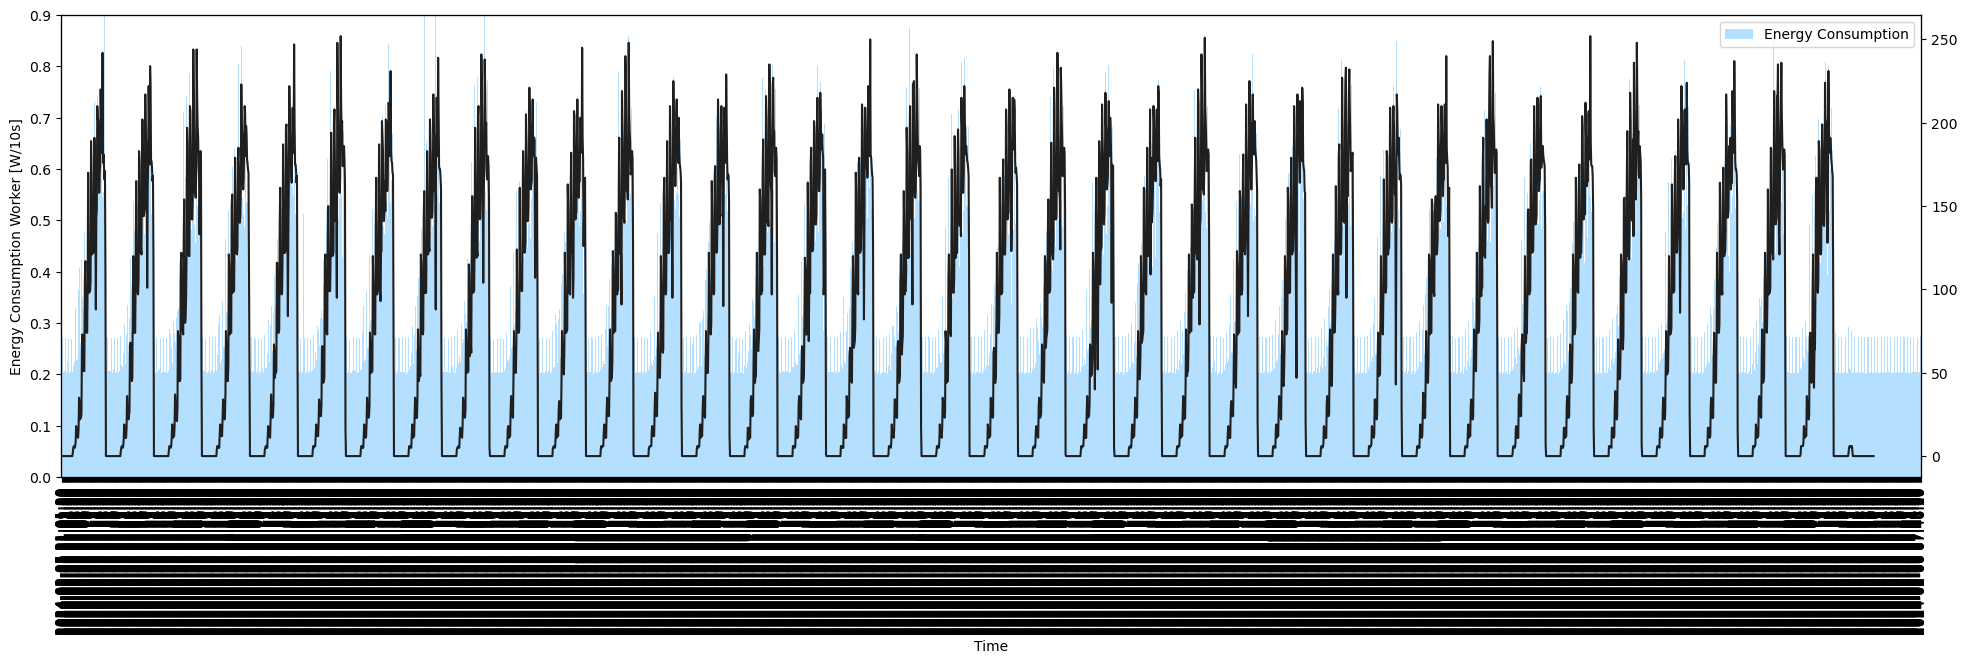

In [ ]:
# Plot completion and power as time series
figsize= [24,6]


# Plotting
ax = completion_and_power['power'].plot(
    kind='bar',
    width=1,
    alpha=0.8,
    color= blue, 
    label='Energy Consumption',
    ylim=[0,0.9],
    xticks=None,
    figsize=figsize
    )

ax.set_ylabel('Energy Consumption Worker [W/10s]')

# Create secondary y-axis
ax2 = ax.twinx()
completion_and_power['completion'].plot(
    ax=ax2, 
    color=black, 
    label='Job Completion',
    xticks=None,
    secondary_y=True)
ax2.set_ylabel('Job Completion [1/s]')

# Combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper right')

plt.show()

<Axes: xlabel='Time'>

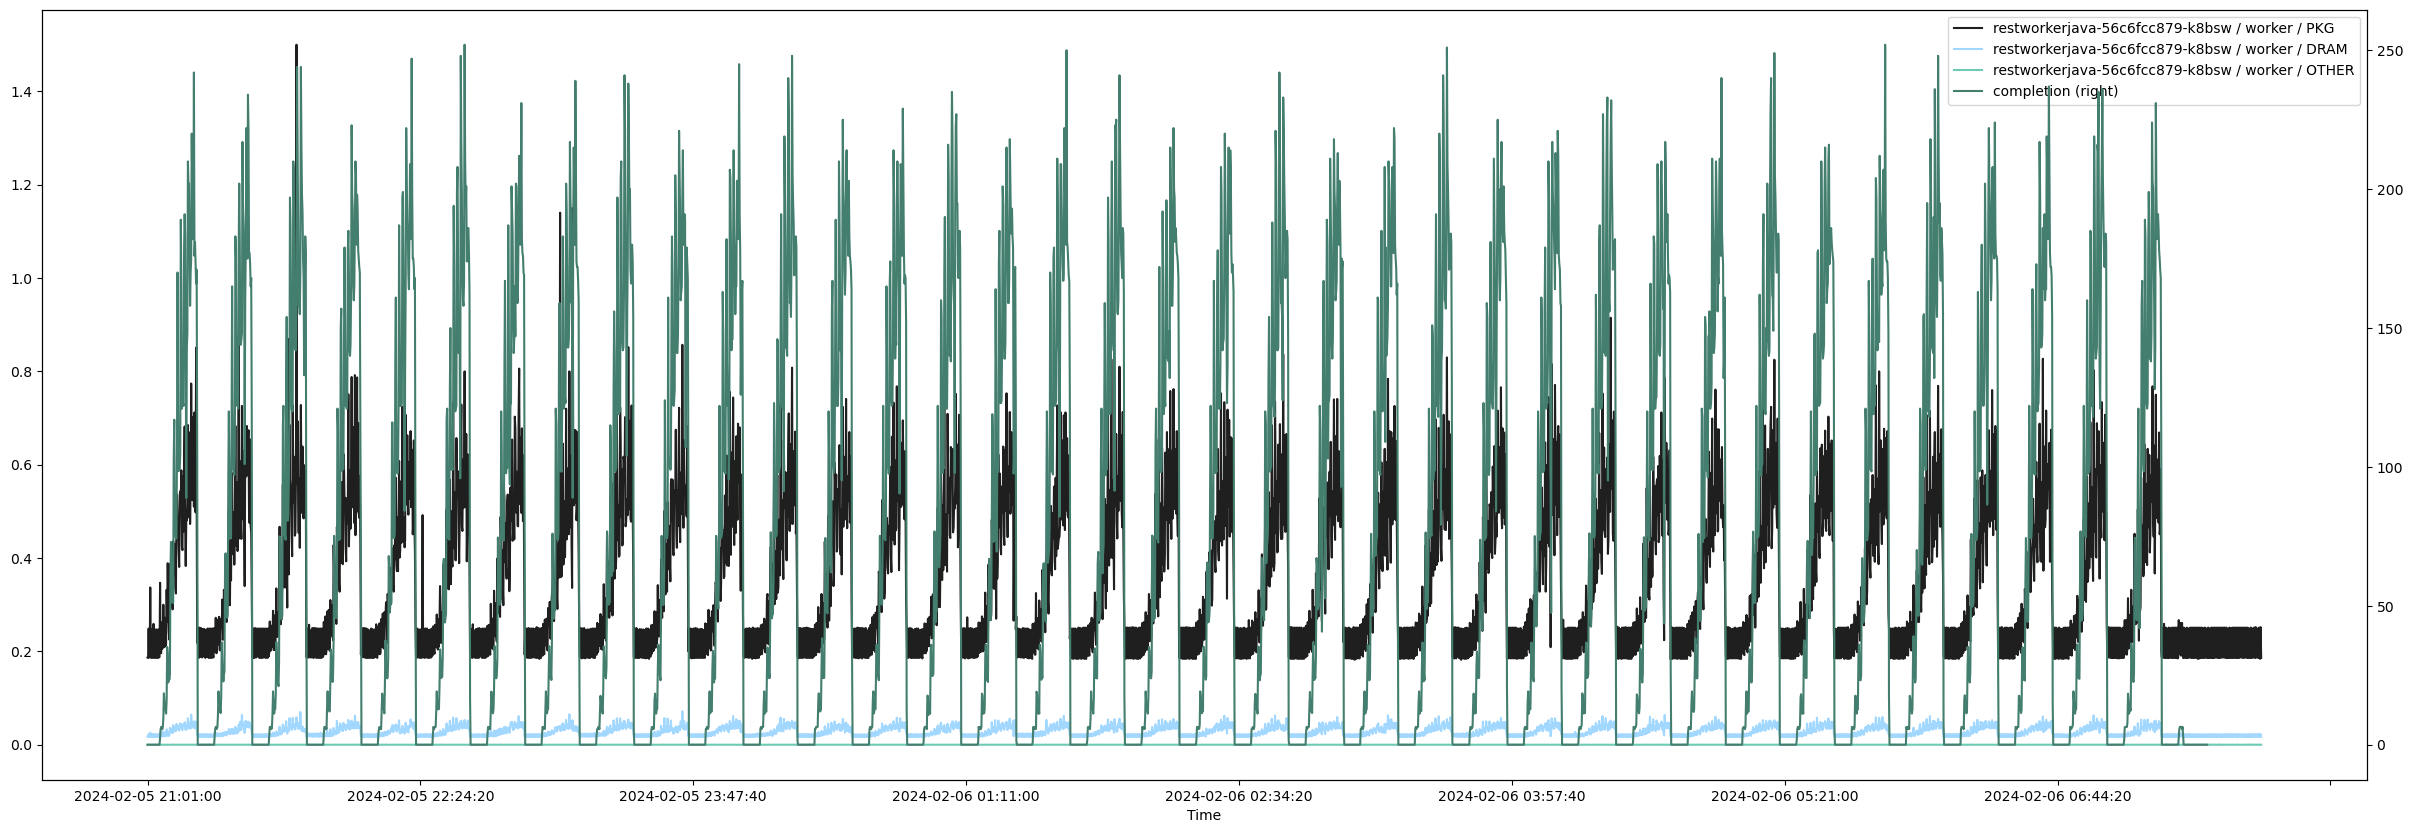

In [ ]:
# raw plot

raw_plot = pd.DataFrame(worker_power.loc['2024-02-05 21:01:00':,:])
raw_plot['completion'] = worker_jobs

raw_plot.plot(secondary_y='completion', color=[black, blue, lightgreen, green], figsize=[30,10])

In [ ]:
# create Table with Key Indicators

indicators = pd.DataFrame(columns = ['Energieverbrauch', 'Durchsatz'])

indicators.loc['Minimum', 'Energieverbrauch'] = completion_and_power['power'].min()
indicators.loc['Maximum', 'Energieverbrauch'] = completion_and_power['power'].max()
indicators.loc['Minimum', 'Durchsatz'] = completion_and_power['completion'].min()
indicators.loc['Maximum', 'Durchsatz'] = completion_and_power['completion'].max()

indicators

,Energieverbrauch,Durchsatz
Minimum,0.1991,0.0
Maximum,1.5588,252.0


---
### Messvorbereitung

Zeebe Dashboard importieren
Skript vorbereiten (Prozessname, Array, etc)
Prozess deployen
Zeebe Port-Forwarding
Timestamp setzen

### Messnachbereitung

Grafana CSV-Export

### ToDo

Skript ändern, so dass Logs Startzeitpunkte in 1 File schreiben
Modulo in shellskript-methode anpassen weil alter scrape intervall war 10sek, jetzt sinds 30Sek

### Notizen

Startzeitpunkt: 2024-02-01 11:40:00 
Modell: load_generator_120j_in_60s

maxjobsactive: 32
pollinterval: 2 # seconds before polling again
timeout: 45
requestTimeout: 30 # how long to keep a request open

---
